# Test 2 methods of modifying spherical intrinsic density profile to axisymmetric.

Question: How to describe the intrinsic density profile of a triaxial/axisymmetric halo of a certain mass?

Suppose the halo has a fixed mass, but the overall shape of the halo is a variable. For a spherical halo, the density on each direction is the same. When varying shape, we can use a 1d profile to describe the density distribution on the intrinsic major axis. 

Method 1: keep the shape of the 1d profile invariant and change the amplitude to conserve mass. 

Method 2: use a rescaled radius s.t. the sphericalized amplitude is the same. 

Goal: check, in projection, which method is less biased compared with a spherical model. 

For simplicity I experiment on axisymmetric model with MGE fit. 

I first use NFW profile, and then change profiles to check if the conclusion is sensitive to different profiles. 

## Spherical model

This is the baseline model. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# MGE fit of the intrinsic density profile
from mgefit.mge_fit_1d import mge_fit_1d

from cycler import cycler
import matplotlib as mpl
clist = ['#04B2D9', '#F2B33D', '#F29966', '#F2441D', '#0486C5']
mpl.rcParams['axes.prop_cycle'] = cycler(color=clist)

First define a spherical NFW profile.

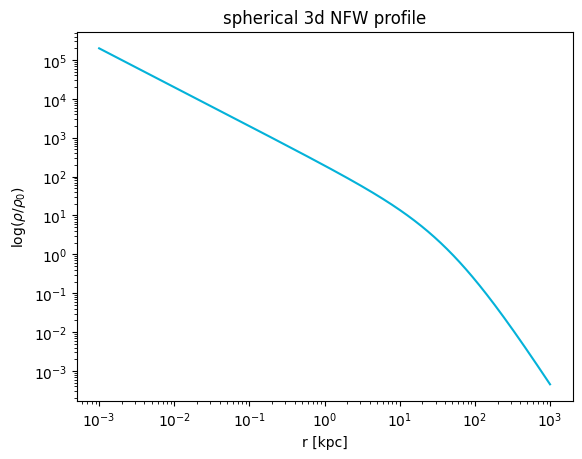

In [2]:
# first define a nfw profile
def Nfw_density(rad, rs, rho0):
    rho = 4 * rho0 / (rad/rs) / (1 + rad/rs)**2
    return rho

rs = 50 #[kpc]
rho0 = 1 
rad = np.geomspace(0.001, 1e3, 500)
rho_sph = Nfw_density(rad, rs, rho0)

plt.loglog(rad, rho_sph)
plt.ylabel(r'log($\rho/\rho_0$)')
plt.xlabel('r [kpc]')
plt.title('spherical 3d NFW profile')
plt.show()

Use multi-Gaussian components to describe the intrinsic density profile.

Intrinsic MGE mass:  15457558.389067307


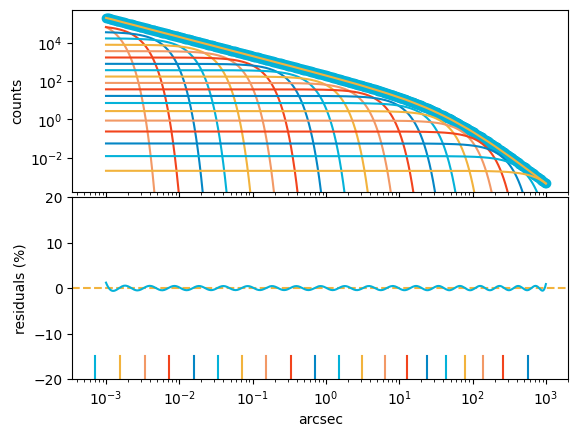

In [3]:
surf0_sph, sigma_sph = mge_fit_1d(x=rad, y=rho_sph, plot=1, quiet=1, ngauss=20).sol
peak_sph = surf0_sph / np.sqrt(2 * np.pi) / sigma_sph

def Intr_mge_mass(peak, sigma, qintr):
    # eq.(37) of Cappellari 2020
    return np.sum(peak * qintr * sigma**3 * np.sqrt(2 * np.pi)**3)

mintr_sph = Intr_mge_mass(peak_sph, sigma_sph, 1)

print('Intrinsic MGE mass: ', mintr_sph)

Calculate the projected property of the MGE component. 

First calculate the projected axis ratio.

In [4]:
# projection of the spherical halo
def Qobs(qintr, inc):
    """compute the observed axis ratio from the intrinsic axis ratio and inclination from eq.(35) of Cappellari 2020

    Args:
        qintr (_type_): intrinsic axis ratio (qintr < 1)
        inc (_type_): inclination angle [rad]

    Returns:
        _type_: observed axis ratio
    """
    qintr1 = np.where(qintr > 1, 1/qintr, qintr)
    Qobs = np.sqrt((qintr1 * np.sin(inc))**2 + np.cos(inc)**2)
    Qobs = np.where(qintr > 1, 1/Qobs, Qobs)
    return Qobs

qobs_sph = Qobs(1, 0.2) # inclination is random due to spherical symmetry
print('Apparent axis ratio: ', qobs_sph)


Apparent axis ratio:  1.0


Calculate the surface density of the MGE component.

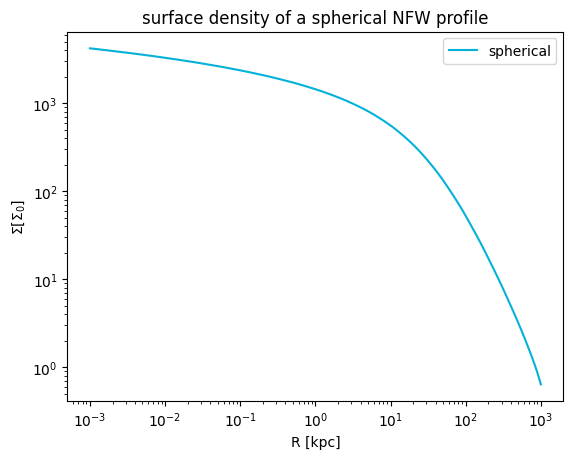

In [5]:
def Peak_surf(peak_intr, sigma_intr, qobs, qintr):
    """calculate the peak amplitude of the surface density MGE using eq.(38) of Cappellari 2020

    Args:
        peak_intr (_type_): peak amplitude of the intrinsic density MGE
        sigma_intr (_type_): sigma of the intrinsic density MGE
        qobs (_type_): observed axis ratio
        qintr (_type_): intrinsic axis ratio

    Returns:
        _type_: peak amplitude of the surface density MGE
    """
    return peak_intr * sigma_intr * np.sqrt(2 * np.pi) * qintr / qobs

surf_sph = Peak_surf(peak_sph, sigma_sph, qobs_sph, 1)

def Sum_gaussian_component(x, peaks, sigmas):
    """sum up the total counts of the Gaussian components

    Args:
        x (_type_): _description_
        peaks (_type_): _description_
        sigmas (_type_): _description_

    Returns:
        float: total counts of all the Gaussians
    """
    total = np.zeros_like(x)

    for i, r in enumerate(x):
        total[i] = np.sum(peaks * np.exp(-1 * r**2 / 2 / sigmas**2))

    return total

surf_gssum_sph = Sum_gaussian_component(rad, surf_sph, sigma_sph)

plt.loglog(rad, surf_gssum_sph, label = 'spherical')
plt.xlabel('R [kpc]')
plt.ylabel(r'$\Sigma [\Sigma_0]$')
plt.title('surface density of a spherical NFW profile')
plt.legend()
plt.show()

## An axisymmetric NFW profile:

Use 2 methods to conserve mass:

Method 1: preserve the radial profile on the intrinsic major axis, squeeze the radial profile on the minor axis, and adjust the amplitude on both axis. 

Method 2: Use a rescaled radius s.t. the sphericalized radial profile is the identical to the spherical NFW profile.

### Method 1:

In [6]:
qintr_oblate = 0.5
qintr_prolate = 1.6

peak_axi_1_prolate = peak_sph / qintr_prolate # essentially modified by qintr
peak_axi_1_oblate = peak_sph / qintr_oblate

print('Rescaled intrinsic mass of the prolate model:', Intr_mge_mass(peak=peak_axi_1_prolate, sigma=sigma_sph, qintr=qintr_prolate))
print('Rescaled intrinsic mass of the oblate model:', Intr_mge_mass(peak=peak_axi_1_oblate, sigma=sigma_sph, qintr=qintr_oblate))
print('Intrinsic mass of the spherical model:', mintr_sph)

Rescaled intrinsic mass of the prolate model: 15457558.389067307
Rescaled intrinsic mass of the oblate model: 15457558.389067307
Intrinsic mass of the spherical model: 15457558.389067307


Compare the intrinsic density of an oblate profile and a spherical profile. Here I compare the sphericalized profile (averaging over the polar and azimuthal angle in a spherical coordinate). To sphericalize a triaxial 3d profile, one replaces the original radius variable with a rescaled one:
$$
r \rightarrow (pq)^{1/3} \sqrt{x^2 + y^2/p^2 + z^2/q^2}.
$$
Here the x, y and z axis are aligned with the intrinsic major, intermediate and minor axis of the ellipsoidal iso-density contours; $p$ is the ratio between the intermediate axis and the major axis, and $q$ is the ratio between the minor axis and the major axis. In the oblate case, $p=1$, $q = qintr$.

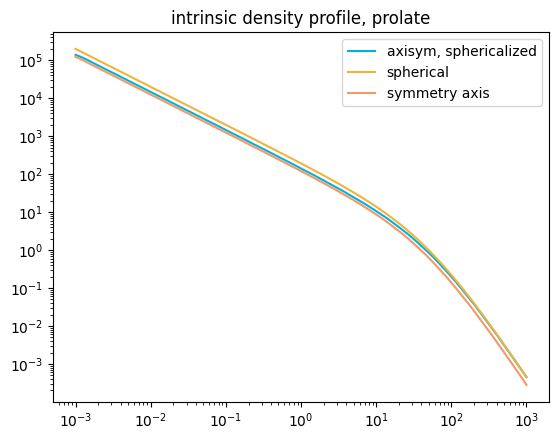

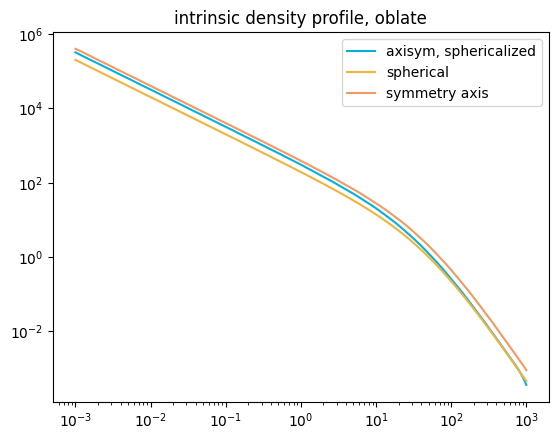

In [7]:
# plot the intrinsic density profile on the major axis vs the intrinsic spherical density profile 
density_axi_1_prolate = Sum_gaussian_component(rad / (qintr_prolate)**(1/3), peak_axi_1_prolate, sigma_sph)
density_axi_1_oblate = Sum_gaussian_component(rad / (qintr_oblate)**(1/3), peak_axi_1_oblate, sigma_sph)

plt.figure()
plt.loglog(rad, density_axi_1_prolate, label = 'axisym, sphericalized')
plt.loglog(rad, rho_sph, label = 'spherical')
plt.loglog(rad, Sum_gaussian_component(rad, peak_axi_1_prolate, sigma_sph), label = 'symmetry axis')
plt.legend()
plt.title('intrinsic density profile, prolate')
plt.show()

plt.figure()
plt.loglog(rad, density_axi_1_oblate, label = 'axisym, sphericalized')
plt.loglog(rad, rho_sph, label = 'spherical')
plt.loglog(rad, Sum_gaussian_component(rad, peak_axi_1_oblate, sigma_sph), label = 'symmetry axis')
plt.legend()
plt.title('intrinsic density profile, oblate')
plt.show()

Below is an example surface density profile.

Projected axis ratio:  1.000761954173269


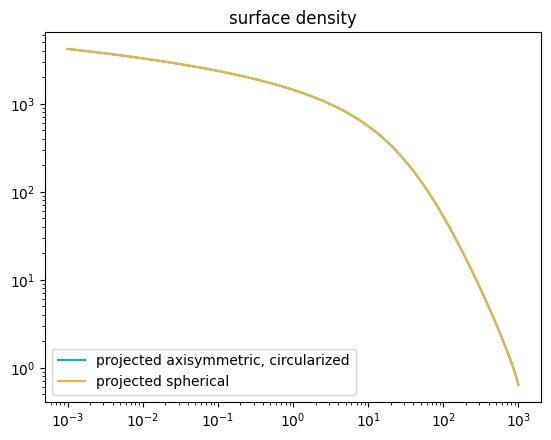

In [8]:
# projection of the intrinsic MGE

inc = 0.05 # almost face-on

qobs_axi_1 = Qobs(qintr_prolate, inc)
print('Projected axis ratio: ', qobs_axi_1)
surf_axi_1 = Peak_surf(peak_axi_1_prolate, sigma_sph, qobs_axi_1, qintr_prolate)

# sum the Gaussians to obtain the projected, circularized radial profile 
surf_gssum_axi_1 = Sum_gaussian_component(rad / np.sqrt(qobs_axi_1), surf_axi_1, sigma_sph)

plt.figure()
plt.loglog(rad, surf_gssum_axi_1, label = 'projected axisymmetric, circularized')
plt.loglog(rad, surf_gssum_sph, label = 'projected spherical')
plt.title('surface density')
plt.legend()
plt.show()


We want to check if the surface density profile of a axisymmetric model is biased w.r.t the spherical model. Therefore, we project the intrinsic profile uniformly on a sphere and stack all the surface density profiles.

In [9]:
def surf_den_avg(proj_num, qintr, peak_axi, sigma_axi, rad):
    """calculate the stacked surface density profile for an oblate intrinsic density profile

    Args:
        proj_num (_type_): total number of projections
        qintr (_type_): intrinsic axis ratio
        peak_axi (_type_): peak of the Gaussian components describing intrinsic density on the symmetry axis
        sigma_axi (_type_): sigma of the Gaussian components describing the intrinsic density on the symmetry axis
        rad (_type_): radius variable

    Returns:
        _type_: stacked surface density corresponding to rad
    """
    cos_inc = np.random.uniform(0, 1, proj_num) # sample inclination angle uniformly from a sphere
    inc = np.arccos(cos_inc)

    surf_all = np.zeros(shape = (proj_num, len(rad)))

    # projection of the intrinsic mge 
    for i, inclination in enumerate(inc):
        qobs = Qobs(qintr, inclination)
        surf_axi = Peak_surf(peak_axi, sigma_axi, qobs, qintr)
        surf_gssum = Sum_gaussian_component(rad / np.sqrt(qobs), surf_axi, sigma_axi) # this is the circularized radial profile
        surf_all[i, :] = surf_gssum
        
    surf_avg = np.mean(surf_all, axis=0)
    return surf_avg

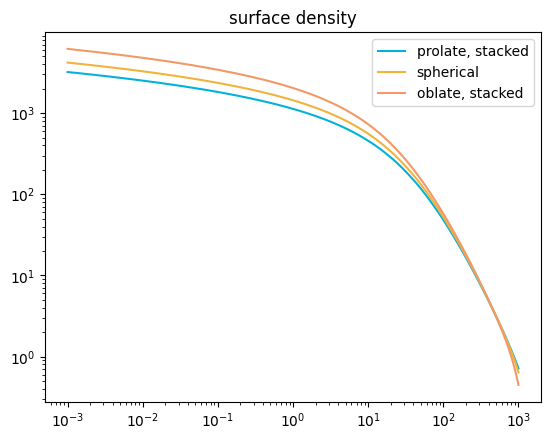

In [10]:
proj_num = 1000
surf_avg_1_prolate = surf_den_avg(proj_num, qintr_prolate, peak_axi_1_prolate, sigma_sph, rad)
surf_avg_1_oblate = surf_den_avg(proj_num, qintr_oblate, peak_axi_1_oblate, sigma_sph, rad)

plt.figure()
plt.loglog(rad, surf_avg_1_prolate, label = 'prolate, stacked')
plt.loglog(rad, surf_gssum_sph, label = 'spherical')
plt.loglog(rad, surf_avg_1_oblate, label = 'oblate, stacked')
plt.title('surface density')
plt.legend()
plt.show()

### Method 2: 

Use the rescaled radius in the density expression. Essentially first extend the iso-density contour along the major axis and then squeeze the iso-density coutour along the minor axis.

The sphericalized density is identical to the spherical density profile.

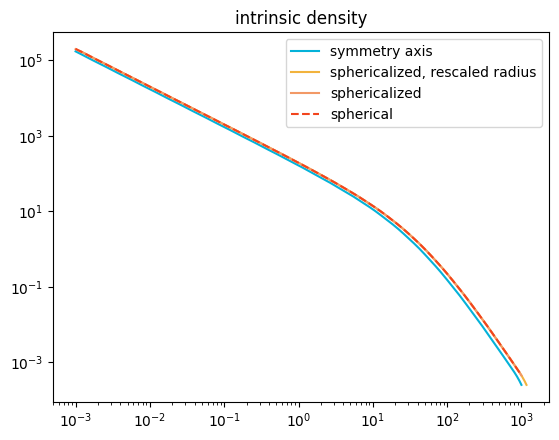

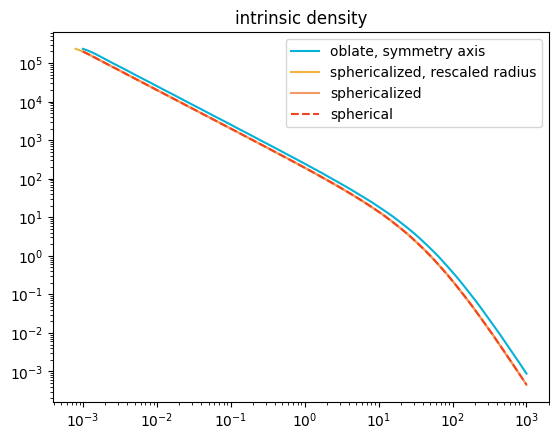

In [11]:
sigma_axi_prolate = sigma_sph / qintr_prolate**(1/3)
sigma_axi_oblate = sigma_sph / qintr_oblate**(1/3)

rho2_prolate = Sum_gaussian_component(rad, peak_sph, sigma_axi_prolate) # on the symmetry axis
rho2_prolate_sph = Sum_gaussian_component(rad / qintr_prolate**(1/3), peak_sph, sigma_axi_prolate) # sphericalized

rho2_oblate = Sum_gaussian_component(rad, peak_sph, sigma_axi_oblate) # on the symmetry axis
rho2_oblate_sph = Sum_gaussian_component(rad / qintr_oblate**(1/3), peak_sph, sigma_axi_oblate) # sphericalized

plt.figure()
plt.loglog(rad, rho2_prolate, label = 'symmetry axis')
plt.loglog(rad * qintr_prolate**(1/3), rho2_prolate, label = 'sphericalized, rescaled radius')
plt.loglog(rad, rho2_prolate_sph, label = 'sphericalized')
plt.loglog(rad, rho_sph, label = 'spherical', ls = '--')
plt.title('intrinsic density')
plt.legend()
plt.show()

plt.figure()
plt.loglog(rad, rho2_oblate, label = 'oblate, symmetry axis')
plt.loglog(rad * (qintr_oblate)**(1/3), rho2_oblate, label = 'sphericalized, rescaled radius')
plt.loglog(rad, rho2_oblate_sph, label = 'sphericalized')
plt.loglog(rad, rho_sph, label = 'spherical', ls = '--')
plt.title('intrinsic density')
plt.legend()
plt.show()

In [12]:
# test MGE mass
print('Intrinsic MGE mass of prolate: ', Intr_mge_mass(peak_sph, sigma_axi_prolate, qintr_prolate))
print('Intrinsic MGE mass of oblate: ', Intr_mge_mass(peak_sph, sigma_axi_oblate, qintr_oblate))

Intrinsic MGE mass of prolate:  15457558.389067303
Intrinsic MGE mass of oblate:  15457558.389067303


An example surface density profile.

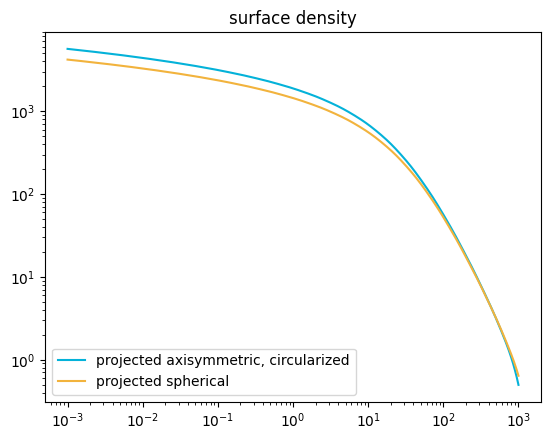

In [13]:
# projection of the intrinsic mge

inc = 0.05
qobs_axi_2_prolate = Qobs(qintr_prolate, inc)
surf_axi_2_prolate = Peak_surf(peak_sph, sigma_axi_prolate, qobs_axi_2_prolate, qintr_prolate)

# sum the Gaussians to obtain the projected, circularized radial profile 
surf_gssum_axi_2_prolate = Sum_gaussian_component(rad / np.sqrt(qobs_axi_2_prolate), surf_axi_2_prolate, sigma_axi_prolate)

plt.figure()
plt.loglog(rad, surf_gssum_axi_2_prolate, label = 'projected axisymmetric, circularized')
plt.loglog(rad, surf_gssum_sph, label = 'projected spherical')
plt.title('surface density')
plt.legend()
plt.show()


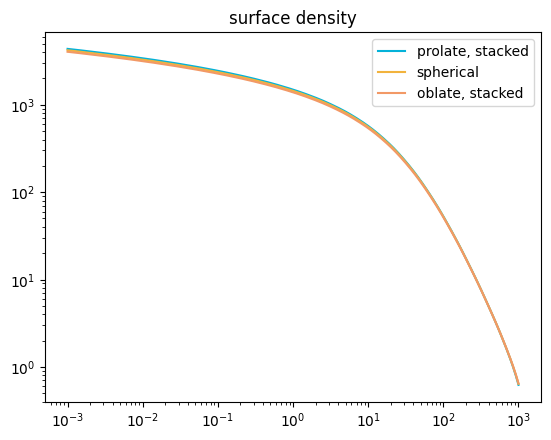

In [14]:
proj_num = 1000
surf_avg_2_prolate = surf_den_avg(proj_num, qintr_prolate, peak_sph, sigma_axi_prolate, rad) 
surf_avg_2_oblate = surf_den_avg(proj_num, qintr_oblate, peak_sph, sigma_axi_oblate, rad) 

plt.loglog(rad, surf_avg_2_prolate, label = 'prolate, stacked')
plt.loglog(rad, surf_gssum_sph, label = 'spherical')
plt.loglog(rad, surf_avg_2_oblate, label = 'oblate, stacked')
plt.title('surface density')
plt.legend()
plt.show()

/tmp/ipykernel_1165688/1706484309.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


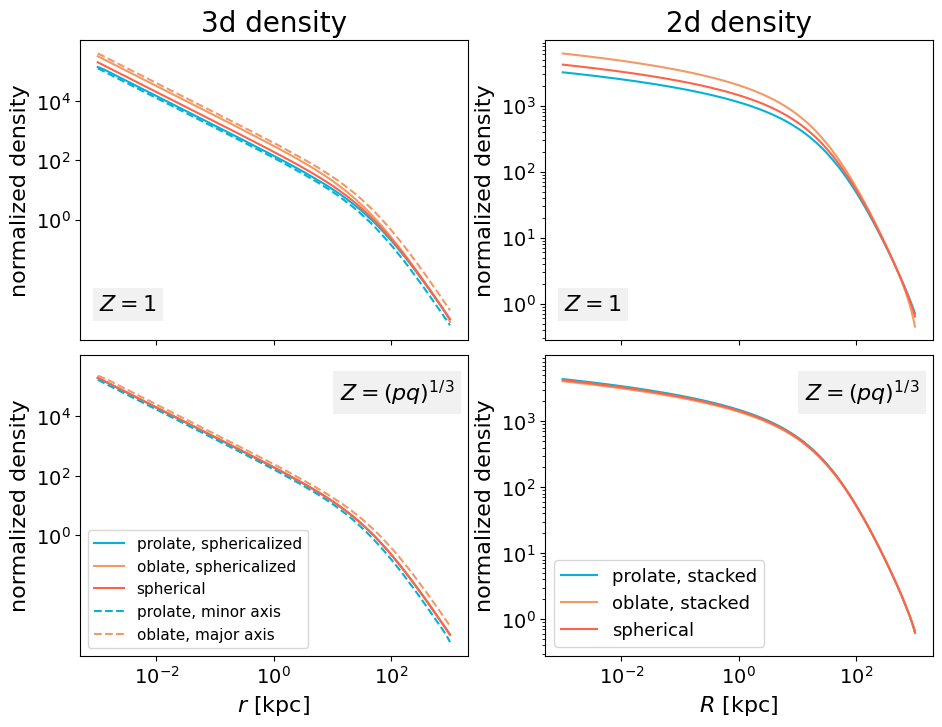

In [24]:
fig = plt.figure(figsize = (11, 8))
gs = fig.add_gridspec(2, 2, hspace=0.05)
axs = gs.subplots(sharex='col')

color_sph = 'tomato'
color_prolate = clist[0]
color_oblate = clist[2]

rad_log = np.log10(rad)

for ax in axs.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.xaxis.label.set(fontsize=16)
    ax.yaxis.label.set(fontsize=16)
    ax.tick_params(axis='both', labelsize = 14)

axs[0, 0].plot(rad, density_axi_1_prolate, label = 'prolate, sphericalized', color = color_prolate)
axs[0, 0].plot(rad, density_axi_1_oblate, label = 'oblate, sphericalized', color = color_oblate)
axs[0, 0].plot(rad, rho_sph, label = 'spherical', color = color_sph, ls = '-')
axs[0, 0].plot(rad, Sum_gaussian_component(rad, peak_axi_1_prolate, sigma_sph), label = 'prolate, minor axis', color = color_prolate, ls = '--')
axs[0, 0].plot(rad, Sum_gaussian_component(rad, peak_axi_1_oblate, sigma_sph), label = 'oblate, major axis', color = color_oblate, ls = '--')
axs[0, 0].set_ylabel('normalized density')
# axs[0, 0].legend(prop = {'size': 10})
axs[0, 0].set_title('3d density', size = 20)


axs[1, 0].plot(rad, rho2_prolate_sph, label = 'prolate, sphericalized', color = color_prolate)
axs[1, 0].plot(rad, rho2_oblate_sph, label = 'oblate, sphericalized', color = color_oblate)
axs[1, 0].plot(rad, rho_sph, label = 'spherical', color = color_sph, ls = '-')
axs[1, 0].plot(rad, rho2_prolate, label = 'prolate, minor axis', color = color_prolate, ls = '--')
axs[1, 0].plot(rad, rho2_oblate, label = 'oblate, major axis', color = color_oblate, ls = '--')
axs[1, 0].sharey(axs[0, 0])
axs[1, 0].set_yticks(10 ** np.arange(0, 5, 2, dtype=float))
axs[1, 0].set_xticks(10 ** np.arange(-2, 3, 2, dtype=float))
axs[1, 0].set_xlabel('$r$ [kpc]')
axs[1, 0].set_ylabel('normalized density')
axs[1, 0].legend(prop = {'size': 11}, loc = 'lower left')

# annotate Z value
props = dict(boxstyle = 'square', facecolor = 'lightgrey', alpha = 0.3, edgecolor = 'None')
axs[0, 0].text(0.05, 0.1, r'$Z = 1$', transform = axs[0, 0].transAxes, fontsize = 16, bbox = props)
axs[0, 1].text(0.05, 0.1, r'$Z = 1$', transform = axs[0, 1].transAxes, fontsize = 16, bbox = props)

axs[0, 1].plot(rad, surf_avg_1_prolate, label = 'prolate, stacked', color = color_prolate)
axs[0, 1].plot(rad, surf_avg_1_oblate, label = 'oblate, stacked', color = color_oblate)
axs[0, 1].plot(rad, surf_gssum_sph, label = 'spherical', color = color_sph)
axs[0, 1].set_ylabel('normalized density')
axs[0, 1].set_title('2d density', size = 20)

axs[1, 1].plot(rad, surf_avg_2_prolate, label = 'prolate, stacked', color = color_prolate)
axs[1, 1].plot(rad, surf_avg_2_oblate, label = 'oblate, stacked', color = color_oblate)
axs[1, 1].plot(rad, surf_gssum_sph, label = 'spherical', color =color_sph)
axs[1, 1].sharey(axs[0, 1])
axs[1, 1].set_xticks(10 ** np.arange(-2, 3, 2, dtype=float))
axs[1, 1].set_xlabel('$R$ [kpc]')
axs[1, 1].set_ylabel('normalized density')
axs[1, 1].legend(loc = 'lower left', prop = {'size': 13})

# annotate Z value
axs[1, 0].text(0.67, 0.85, r'$Z = (pq)^{1/3}$', transform = axs[1, 0].transAxes, fontsize = 16, bbox = props)
axs[1, 1].text(0.67, 0.85, r'$Z = (pq)^{1/3}$', transform = axs[1, 1].transAxes, fontsize = 16, bbox = props)

# Adjust layout to prevent overlapping titles
plt.tight_layout()

plt.savefig('./appdxB_compare_sphericalizing.pdf', bbox_inches='tight', dpi=300)

plt.show()

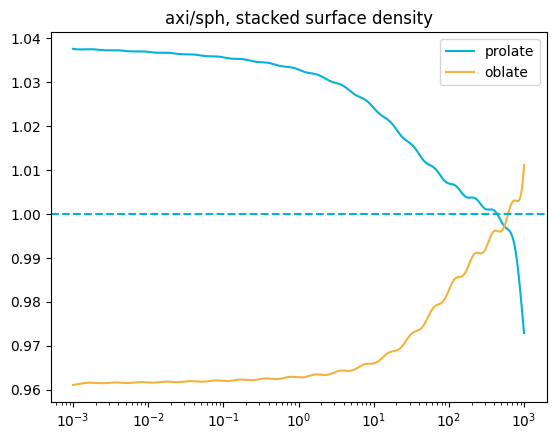

In [16]:
plt.plot(rad, surf_avg_2_prolate / surf_gssum_sph, label = 'prolate')
plt.plot(rad, surf_avg_2_oblate / surf_gssum_sph, label = 'oblate')
plt.axhline(1, ls = '--')
plt.xscale('log')
plt.title('axi/sph, stacked surface density')
plt.legend()
plt.show()